Alireza Kheirandihs

Student Number : 97101604

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [71]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=y.clone().detach(),
                                                                                    value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=y.clone().detach(),
                                                                                    value=1))
)

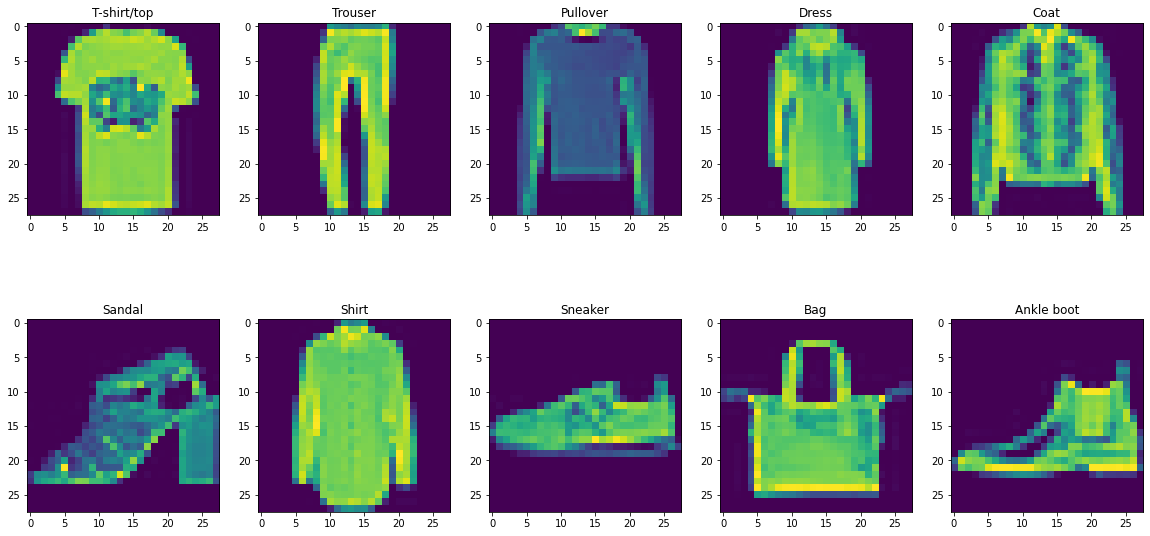

In [72]:
labels = training_data.classes

fig, ax = plt.subplots(nrows=2, ncols=5,figsize = (20,10))

for i in range(len(labels)):
    idx = np.argwhere(training_data.targets == i).numpy()[0]
    idx = np.random.choice(idx, 1)[0]
    ax[i//5,i-5*(i>4)].imshow(training_data.data[idx].numpy())
    ax[i//5,i-5*(i>4)].set_title(labels[i])


In [73]:
input_size = training_data.data[0].shape[0] * training_data.data[0].shape[1]
output_size = len(training_data.classes)

In [109]:
class MyNet():
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = 3
        n_out1 = 13
        n_out2 = 7
        self.etha = 0.01
        self.w1 = self.etha * torch.randn((self.input_size, n_out1), requires_grad=True)
        self.b1 = self.etha * torch.randn((1, n_out1), requires_grad=True)
        self.w2 = self.etha * torch.randn((n_out1, n_out2), requires_grad=True)
        self.b2 = self.etha * torch.randn((1, n_out2), requires_grad=True)
        self.w3 = self.etha * torch.randn((n_out2, self.output_size), requires_grad=True)
        self.b3 = self.etha * torch.randn((1, self.output_size), requires_grad=True)
        self.W = [self.w1, self.w2, self.w3]
        self.b = [self.b1, self.b2, self.b3]

        relu = lambda x: x * (x > 0)
        self.softmax = lambda x: torch.exp(x) / torch.exp(x).sum(axis=0)
        
        self.activation_1 = relu
        self.activation_2 = relu
        self.activation = [self.activation_1, self.activation_2, self.softmax]

    def model(self, xb):
        out = xb.clone().detach().requires_grad_(True)
        for i in range(len(self.W)):
            out = out @ self.W[i] + self.b[i]
            out = self.activation[i](out)
        yb = out
        return yb
    
    def loss(self, y_pred, y_true):
        cross_entropy = torch.sum(-1.0*torch.log(y_pred) * y_true) / y_true.shape[0]
        return cross_entropy 
    
    def eval(self, X, y_one_hot):
        probs = self.model(X)
        loss_out = self.loss(probs, y_one_hot).detach().item()
        y_pred = probs.argmax(axis=1)
        y_true = y_one_hot.argmax(axis=1)
        acc_out = np.array(torch.sum(y_pred == y_true) / X.shape[0])
        return acc_out, loss_out 

    def train(self, train_data, test_data, n_epochs, batch_size, lr=0.01):

        X_train = train_data.data.reshape((-1, self.input_size)).float()
        y_train = train_data.targets
        X_test = test_data.data.reshape((-1, self.input_size)).float()
        y_test = test_data.targets
        y_train_one_hot = [train_data.target_transform(train_data.targets[i]).reshape((1, -1)) for i in range(len(train_data))]
        y_train_one_hot = torch.cat(y_train_one_hot, axis=0)
        y_test_one_hot = [test_data.target_transform(test_data.targets[i]).reshape((1, -1)) for i in range(len(test_data))]
        y_test_one_hot = torch.cat(y_test_one_hot, axis=0)

        n_batchs = X_train.shape[0] // batch_size
        for epoch in range(n_epochs):
            lr_train = lr/(epoch+1)
            idx = 0
            for batch in range(n_batchs):
                y_batch = torch.zeros((batch_size, self.output_size),  dtype=float)
                X_batch = X_train[idx:idx+batch_size, :]
                y_batch = y_train_one_hot[idx:idx+batch_size, :]              
                probs = self.model(X_batch)
                loss = self.loss(probs, y_batch)
                for i in range(len(self.W)):
                    self.W[i].retain_grad()
                    self.b[i].retain_grad()
                loss.backward(retain_graph=True)
                for i in range(len(self.W)):
                    # print("grad", self.W[i].grad)
                    self.W[i] = self.W[i] - lr_train * self.W[i].grad
                    self.b[i] = self.b[i] - lr_train * self.b[i].grad
                idx += batch_size

            training_acc, training_loss = self.eval(X_train, y_train_one_hot)
            test_acc, test_loss = self.eval(X_test, y_test_one_hot)

            probs = self.model(X_train)
            y_pred = probs.argmax(axis=1)
            

            print(f"#{epoch}: training={training_acc*100}%, test={test_acc*100}%\n")
#         if R == 1:
        return y_pred
            

In [110]:
net = MyNet(input_size=input_size, output_size=output_size)
# torch.save(net.state_dict(), ".\")
y_pred = net.train(training_data, test_data, 5, 40)

#0: training=81.781667470932%, test=80.77999949455261%

#1: training=83.61166715621948%, test=82.27999806404114%



KeyboardInterrupt: 

tensor(2)

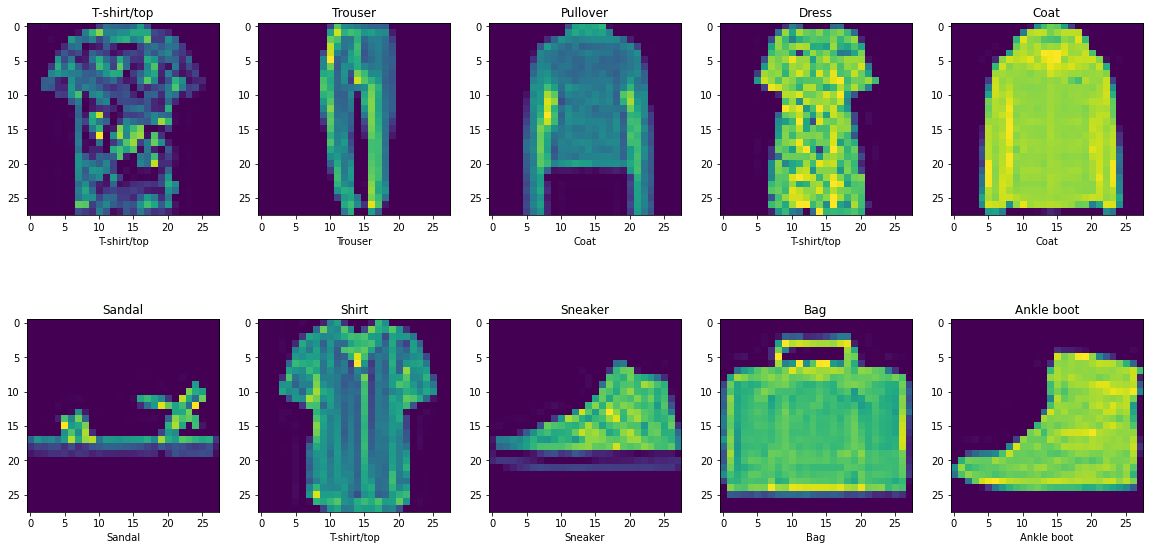

In [108]:
labels = training_data.classes

fig, ax = plt.subplots(nrows=2, ncols=5,figsize = (20,10))

for i in range(len(labels)):
    idx = np.argwhere(training_data.targets == i).numpy()[0]
    idx = np.random.choice(idx, 1)[0]
    ax[i//5,i-5*(i>4)].imshow(training_data.data[idx].numpy())
    ax[i//5,i-5*(i>4)].set_title(labels[i])
    ax[i//5,i-5*(i>4)].set_xlabel(labels[y_pred[idx].numpy()])
#     ax.

In [100]:
labels

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [54]:
# x.clone().detach().requires_grad_(True)

tensor([[ 0.9055],
        [ 0.5542],
        [-0.2442],
        [ 0.1809],
        [-2.0695]], requires_grad=True)

In [ ]:
ax.x